This notebook uses the lat/lon rasters we produced in the previous notebook and [`rasterio.plot`](https://rasterio.readthedocs.io/en/latest/topics/plotting.html) module to make figures we use in our paper.

**Warning**: Everything is exposed because:

+ matplotlib makes updates 
+ we anticipate users will want to customize their own plots for their own analyses

In [1]:
import rasterio
from rasterio.transform import array_bounds
import geopandas as gpd
from shapely.geometry import Point

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

from pathlib import Path
from tqdm import tqdm
import networkx as nx

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import colors, colorbar, cm
from matplotlib.colors import LinearSegmentedColormap

from orinoco import get_cropped_profile, export_nodes_to_geodataframe

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)

# Directories of Orinoco Products

Again there are two options:

1. `stamen_terrain_12`
2. `google_16`

Toggle the map name to change. **We assume you have run the previous notebooks using said option.**

In [2]:
# options are `stamen_terrain_12` or `google_16`
map_name = 'stamen_terrain_12'

In [3]:
data_path = Path(f'data/{map_name}')
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir_4326 = Path(f'{products_for_map_dir}_4326')

# Intialize a Directory for Plots

In [4]:
plot_dir = Path('plots')
plots_for_maps_dir = plot_dir/f'{map_name}'
plots_for_maps_dir.mkdir(exist_ok=True, parents=True)

# Open the rasters

We also provide a sample plot using `rasterio`.

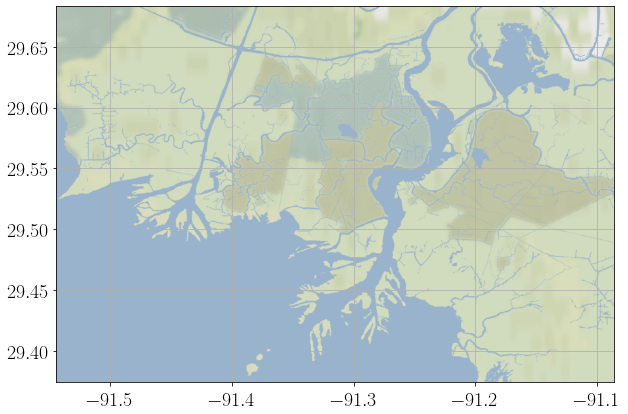

In [5]:
from rasterio import plot

fig, ax = plt.subplots(figsize=(10, 10))

with rasterio.open(products_for_map_dir_4326/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(products_for_map_dir_4326/'water_mask.tif') as ds:
    water_mask = ds.read(1)

with rasterio.open(products_for_map_dir_4326/f'{map_name}.tif') as ds:
    stamen_arr = ds.read()
    transform = ds.transform
    profile = ds.profile

plot.show(stamen_arr, ax=ax, transform=transform)
ax.grid('on', zorder=2)
ds.close()

We also will set nodata in our ocean mask to `np.nan` so it is transparent in our plots.

In [6]:
ocean_layer = ocean_mask.astype(dtype=float)
ocean_layer[~ocean_mask.astype(bool)] = np.nan

We also open the vector data (which is easily converted to lat/lon using geopandas).

/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the pre

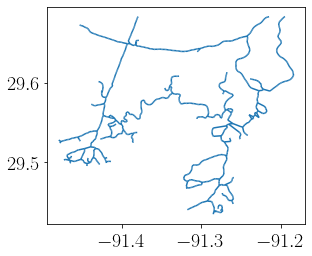

In [7]:
nodes_df = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson').to_crs({'init':'epsg:4326'})
edges_df = gpd.read_file(products_for_map_dir/'orinoco_edges.geojson').to_crs({'init':'epsg:4326'})
widths_df = gpd.read_file(products_for_map_dir/'width_geometries.geojson').to_crs({'init':'epsg:4326'})
widths_df = widths_df[~widths_df.geometry.is_empty]
edges_df.plot()

# Plots

## Visualizing the Initial Products

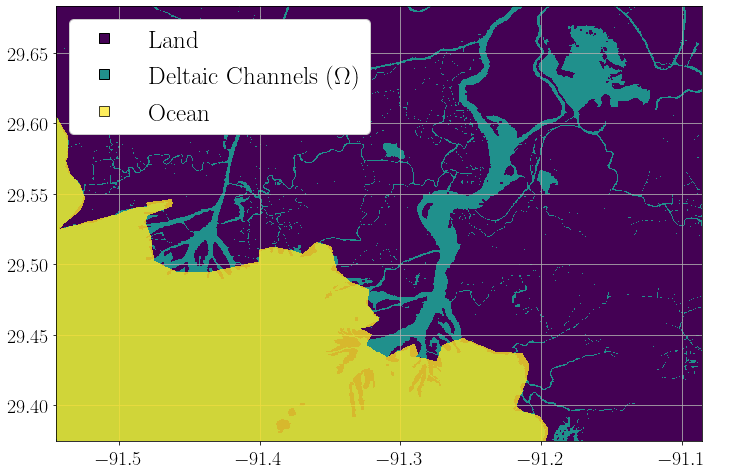

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
plot.show(water_mask, ax=ax, transform=transform, zorder=1,  vmin=0, vmax=2, interpolation='none')
plot.show(ocean_layer, ax=ax, transform=transform, zorder=2, cmap='viridis', vmin=0, vmax=1, alpha=.8, interpolation='none')
ax.grid('on', zorder=5)



########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

M = 3
labels = ['Land', 'Deltaic Channels ($\Omega$)', 'Ocean']
cNorm  = colors.Normalize(vmin=0, vmax=(M-1))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          alpha=alpha,
                          markersize=10) for alpha, k in zip([1, 1, .75], range(M))]
ax.legend(handles=legend_elements, loc='upper left', fontsize=25,  framealpha=1)


################
# Empty Colorbar
###############

# To match size of other figures

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2.5%', pad=0.07)
cax.axis('off')


plt.savefig(plots_for_maps_dir/'landcover_init.png')

## Visualizing the Distance Function $\varphi$

We first visialize the interface as the area within 200 meters of the interface. Then we perform additional dilation, again all for visualization.

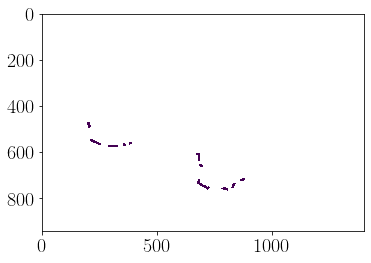

In [9]:
with rasterio.open(products_for_map_dir_4326/'distance.tif') as ds:
    distance = ds.read(1)
    transform = ds.transform
    
interface = (distance.copy() < 200)
interface = nd.binary_dilation(interface.astype(int), iterations=3).astype(float)
interface[~(interface >0)] = np.nan
plt.imshow(interface, interpolation='none')

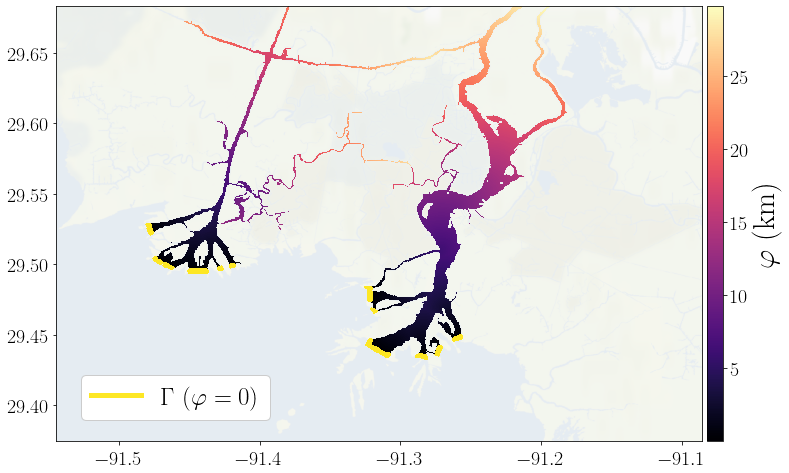

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))


plot.show(interface, ax=ax, transform=ds.transform, 
          zorder=2, cmap='viridis',vmin=0, vmax=1, interpolation='none')
cmap = 'magma'
D = distance/1_000
plot.show(distance/1_000, ax=ax, transform=ds.transform, zorder=1, cmap=cmap, interpolation='none')
plot.show(stamen_arr, ax=ax, transform=ds.transform, zorder=0, alpha=.25)


##########
# Colorbar
##########

# Source: https://matplotlib.org/3.1.0/tutorials/colors/colorbar_only.html

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2.5%', pad=0.07)

norm = colors.Normalize(vmin=np.nanmin(D), vmax=np.nanmax(D))
cb1 = colorbar.ColorbarBase(cax, 
                            cmap=plt.get_cmap(cmap),
                            norm=norm,
                            orientation='vertical')
cax.set_ylabel(r'$\varphi$ (km)', fontsize=30)
cax.tick_params(axis='both', which='major', labelsize=20)


########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap='viridis')
legend_elements = [Line2D([0], 
                          [0], 
                          color=scalarMap.to_rgba(1),
                          label=r'$\Gamma$ ($\varphi=0$)',
                          linewidth=5,
                          markersize=10,
                          )]
ax.legend(handles=legend_elements,
          bbox_to_anchor=(.35, .18), 
          fontsize=25,  
          framealpha=1)


plt.savefig(plots_for_maps_dir/'distance.png')

## Visualizing the Channel Segmentation

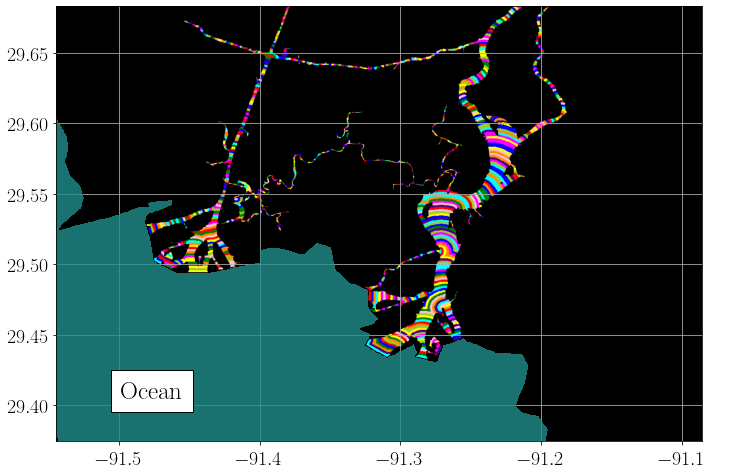

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
ds = rasterio.open(products_for_map_dir_4326/'segments_rgb.tif')
plot.show(ds.read(), ax=ax, transform=ds.transform, zorder=1)
plot.show(ocean_layer, ax=ax, transform=ds.transform, zorder=2, cmap='viridis', vmin=0, vmax=2, alpha=.8)
ax.grid('on', zorder=5)

#########
# Textbox
#########

t = ax.text(.1, .1, 
            r"Ocean", 
            c='black',
            size=25,
            transform=ax.transAxes,
            zorder=4)

t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black', pad=10))


################
# Empty Colorbar
###############

# To match size of other figures

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2.5%', pad=0.07)
cax.axis('off')


plt.savefig(plots_for_maps_dir/'segments.png')
ds.close()

## Visualizing the Centerlines

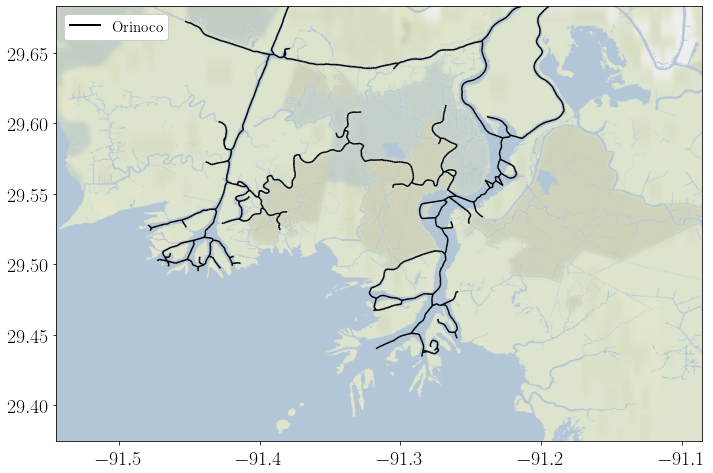

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

plot.show(stamen_arr, ax=ax, transform=ds.transform, zorder=0, alpha=.75)
edges_df.plot(ax=ax, zorder=1, color='black')


########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='black',
                          label='Orinoco',
                          linewidth=2,
                          markersize=10)]

ax.legend(handles=legend_elements, loc='upper left', fontsize=15, framealpha=1)

# Visualizing the Additional Products over a Subset

*Warning*: it gets messy.


## Cropping Products

First we are going to select a subarea in our study area to better visualize the products. Toggle between the `subarea` below or create your own.

In [13]:
# Options are 'Atchafalaya' or 'Wax Lake'
subarea = 'Atchafalaya'

# Atchafalaya
if subarea == 'Atchafalaya':
    sy = np.s_[250:]
    sx = np.s_[600:1150]

# Wax Lake
elif subarea == 'Wax Lake':
    sy = np.s_[250:750]
    sx = np.s_[150:650]
    
else:
    raise ValueError('Not considered')

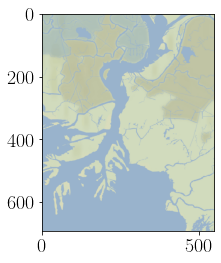

In [14]:
plot.show(stamen_arr[:3, sy, sx])

We use the raster slices to get the relevant geographic data for further slicing and plotting.

In [15]:
profile_cropped = get_cropped_profile(profile, sx, sy)
transform_c = profile_cropped['transform']

x_min, y_min, x_max, y_max = array_bounds(profile_cropped['height'], 
                                          profile_cropped['width'], 
                                          profile_cropped['transform'])

In [16]:
y_min, y_max

(29.374505044320063, 29.60136146455991)

In [17]:
edges_c = edges_df.cx[x_min: x_max, y_min: y_max].copy()
nodes_c = nodes_df.cx[x_min: x_max, y_min: y_max].copy()
widths_c = widths_df.cx[x_min: x_max, y_min: y_max].copy()


stamen_arr_c = stamen_arr[:, sy, sx]
ocean_layer_c = ocean_layer[sy, sx]
water_mask_c = water_mask[sy, sx]

We are going to actually overlay the NetworkX plots so will need to obtain an associated subgraph.

In [18]:
chanG = nx.read_gpickle(products_for_map_dir/'channel_network.pkl')
nodes = [(data['x'], data['y']) for data in nodes_c.to_dict('records')]
H = chanG.subgraph(nodes)
type(H), len(H), list(H.nodes())[0]

(networkx.classes.digraph.DiGraph, 461, (671363.31205456, 3272310.1029821383))

## Visualizing the Subset of Centerlines

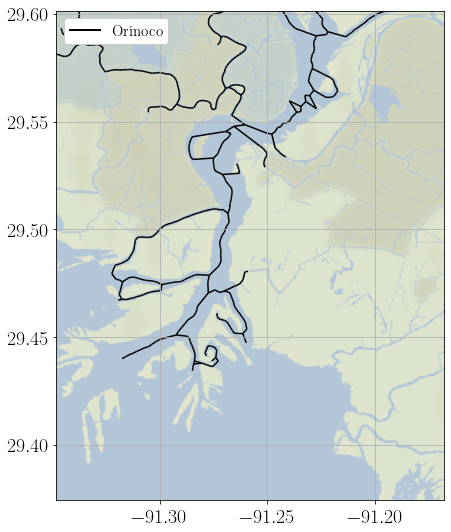

In [19]:
fig, ax = plt.subplots(figsize=(13, 9))

plot.show(stamen_arr_c, ax=ax, transform=transform_c, zorder=0, alpha=.75)
edges_c.plot(ax=ax, zorder=1, color='black')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='black',
                          label='Orinoco',
                          linewidth=2,
                          markersize=10)]
ax.grid('on')
ax.legend(handles=legend_elements, loc='upper left', fontsize=15, framealpha=1)

## Visualizing Distance to Ocean

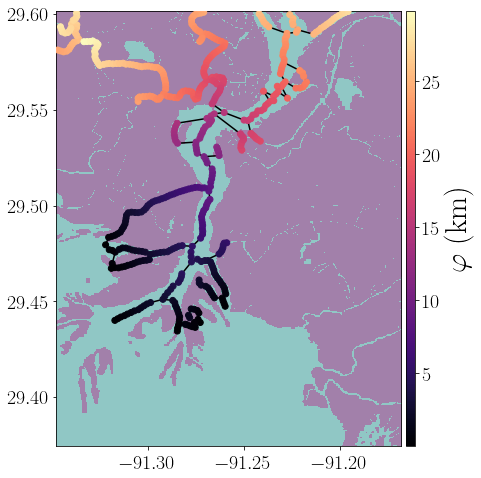

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

edges_c.plot(color='black', ax=ax, alpha=1,zorder=2)
nodes_c['km_to_coast'] = (nodes_c.meters_to_interface.values) / 1_000
nodes_c.plot(column='km_to_coast', ax=ax, cmap='magma', zorder=3, linewidth=1)


##########
# Colorbar
##########

# Source: https://matplotlib.org/3.1.0/tutorials/colors/colorbar_only.html

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2.5%', pad=0.07)

norm = colors.Normalize(vmin=np.nanmin(D), vmax=np.nanmax(D))
cb1 = colorbar.ColorbarBase(cax, 
                            cmap=plt.get_cmap(cmap),
                            norm=norm,
                            orientation='vertical')
cax.set_ylabel(r'$\varphi$ (km)', fontsize=30)
cax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig(plots_for_maps_dir/'cropped_node_dist.png')

## Visualizing The Edge Partition

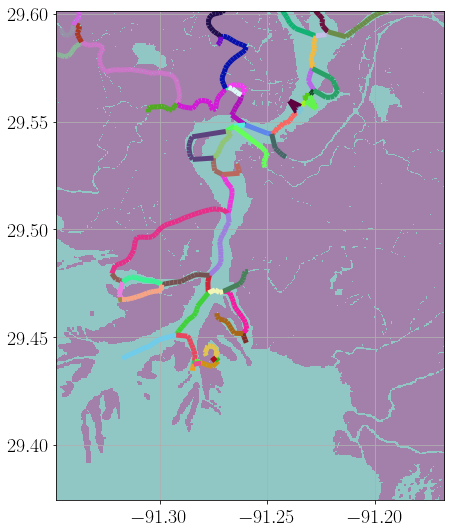

In [21]:
fig, ax = plt.subplots(figsize=(13, 9))

plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

#############
# Random Cmap
#############

# Source: https://stackoverflow.com/a/32520273/2348348

np.random.seed(0)
N = edges_c.shape[0]
color_list = [np.random.random(3) for k in range(N)]
random_colormap = LinearSegmentedColormap.from_list('new_map', color_list, N)


edges_c.plot(column='segment_id', 
             cmap = random_colormap,
             categorical=True,
             ax=ax, 
             zorder=2, 
             linewidth=5)


ax.grid('on')
plt.savefig(plots_for_maps_dir/'cropped_junction_segments.png')

## Visualizing the Stream Flow (Take 1)

To plot the graph, we to use our orignal graph and determine positions quickly. Pyproj could be used but it's slower, so we use geopandas.

In [22]:
# Slower, but equivalent
# from pyproj import Proj, transform
# df_nodes_original = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson')
# inProj = Proj(init=df_nodes_original.crs)
# outProj = Proj(init='epsg:4326')
# pos_r = {node: transform(inProj,outProj,*node) for node in H.nodes()}

# Open the original node file to get CRS
original_crs = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson').crs
# Obtain the node dataframe from H; need to make sure the nodes are precisely the same due to precision in lookup!
df_nodes_original = export_nodes_to_geodataframe(H, crs=original_crs)
df_nodes_original['geometry_coords'] =df_nodes_original['geometry'].map(lambda point: point.coords[0])
df_nodes_original['geometry_coords_r'] =df_nodes_original['geometry'].to_crs({'init': 'epsg:4326'}).map(lambda point: point.coords[0])
pos_r = df_nodes_original.set_index('geometry_coords').to_dict()['geometry_coords_r']

/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


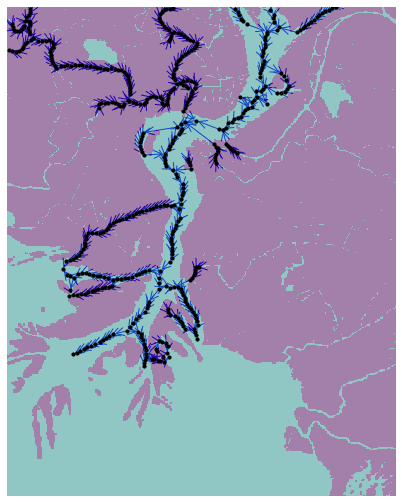

In [23]:
fig, ax = plt.subplots(figsize=(13, 9))

plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

nx.draw(H, 
        pos=pos_r, 
        node_size=10,
        arrows=True,
        arrowsize=20,
        ax=ax,
        node_color='black',
        arrowstyle='->',
        edge_color='blue',
        edgecolor=(0, 0, 0, 0))

ax.grid('on')
ax.tick_params(axis='both',
               which='major',
               labelbottom=True,
               labelleft=True)

## Visualizing the Widths

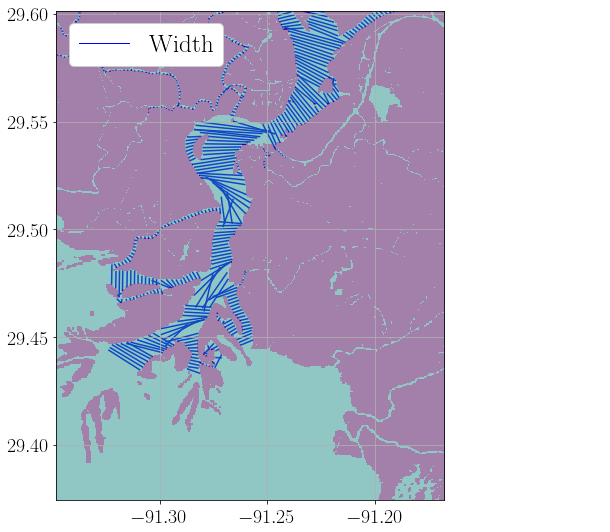

In [24]:
fig, ax = plt.subplots(figsize=(13, 9))

plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=1,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

widths_c.plot(color='blue', ax=ax, zorder=1)



ax.axis('on')
cax = fig.add_axes([0.85, 0.13, 0.04, 0.74])
cax.axis('off')

legend_elements = [Line2D([0], 
                          [0], 
                          marker=None,
                          color='blue',
                          label='Width',
                          linewidth=1,
                          markersize=10)]

ax.legend(handles=legend_elements, loc='upper left', fontsize=25, framealpha=1)

ax.grid('on')

plt.savefig(plots_for_maps_dir/'cropped_widths.png')

## Visualizing The Stream Flow (Take 2)

Yes, this is even messier!

We want an arrow for each segment. We will paritition the edges of our channel nedtwork once more and determine the position of the 1/3rd point (this looked the best).

In [25]:
from orinoco import dfs_line_search, direct_line

# Determine interface nodes
interface_nodes = [node for node, data in H.nodes(data=True) if data['interface_adj']]
node_data = dict(H.nodes(data=True))

# Partition edges
def dfs_line_search_with_interface(G, source):
    def interface_criterion(node):
        return node_data[node]['interface_adj']
    return dfs_line_search(G, source, break_func=interface_criterion)

random_source = interface_nodes[0]
lines = list(dfs_line_search_with_interface(H.to_undirected(), random_source))

# Ensure the lines are oriented
direct_line_partial = lambda line: direct_line(line, node_data)
lines = list(map(direct_line_partial, lines))

# Find edges that are part of group with size bigger than 2 and find 1/3rd point
edges_with_arrows_0 = [line[len(line)//3] for line in lines 
                     if len(line) > 2]
# Make sure we also label the edge groups next to interface
edges_with_arrows_1 = [line[len(line)//3] for line in lines 
                     if (node_data[line[-1][0]]['interface_adj']) | (node_data[line[-1][1]]['interface_adj'])]
edges_with_arrows = edges_with_arrows_0 + edges_with_arrows_1
len(edges_with_arrows)

52

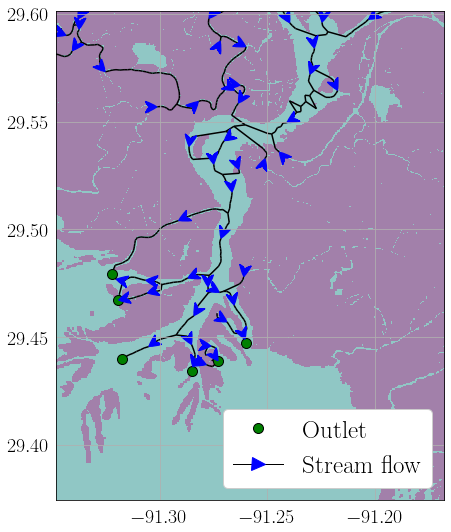

In [26]:
fig, ax = plt.subplots(figsize=(13, 9))
plot.show(water_mask_c, 
          ax=ax, 
          transform=transform_c, 
          zorder=0,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

edges_c.plot(color='black', ax=ax, zorder=1)
nodes_c[nodes_c.interface_adj].plot(color='green', ax=ax, zorder=1, markersize=100, edgecolor='black')



###################
# Edges with Arrows
###################

ins, outs = zip(*edges_with_arrows)
H2 = H.subgraph(list(set(ins + outs)))
nx.draw_networkx_edges(H2, 
                        pos=pos_r,
                        width=1.2,
                        edge_list=edges_with_arrows,
                        node_size=1,
                        arrows=True,
                        arrowstyle="fancy",
                        arrowsize=28,
                        ax=ax,
                        edge_color='blue',
                        zorder=1,
                        alpha=1,
                       )


########
# Legend
########

# source: https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib

legend_elements = [Line2D([0], 
                          [0], 
                          marker='o',
                          color='w',
                          label=f'Outlet',
                          markerfacecolor='green',
                          markeredgecolor='black',
                          alpha=1,
                          markersize=10)]

legend_elements += [Line2D([0], 
                           [0], 
                           marker='>',
                           color='black',
                           markerfacecolor='blue',
                           markeredgecolor='blue',
                           label='Stream flow',
                           linewidth=1,
                           markersize=13)]
ax.legend(handles=legend_elements, loc='lower right', fontsize=25,  framealpha=1)

ax.grid('on')
ax.tick_params(axis='both',
               which='major',
               labelbottom=True,
               labelleft=True)


plt.savefig(plots_for_maps_dir/'cropped_net_dir.png')